In [2]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import matplotlib.pyplot as plt
import statsmodels.api as sm

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [38]:
def calculate_amihud_liquidity(cleansed):
    volume=load_daily_volume()
    contract_size=load_maps()
    fx=load_fx()
    fx_map=contract_size.to_dict()['Currency']
    tick_map=contract_size.to_dict()['Tick Value']
    fx=fx.resample(rule='d',how='last')
    px=cleansed.resample(rule='d',how='last')
    total_vol=pd.DataFrame()
    for m in cleansed.columns:
        try:
            curr= str(fx_map[m])
            total_vol[m] = (px[m]/fx[curr]*volume[m]*tick_map[m])[:'2016'] 
        except:
            print(m)
    x= (cleansed.pct_change().abs()/ total_vol).resample(rule='m',how='median')
    return x.replace([np.inf, -np.inf,0], np.nan)

In [5]:
cleansed=pd.read_csv('extra_px.csv',parse_dates=['Date'],index_col=0)

In [6]:
v=pd.read_csv('extra_vol.csv',parse_dates=['Date'],index_col=0)
#volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')
volume=v

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


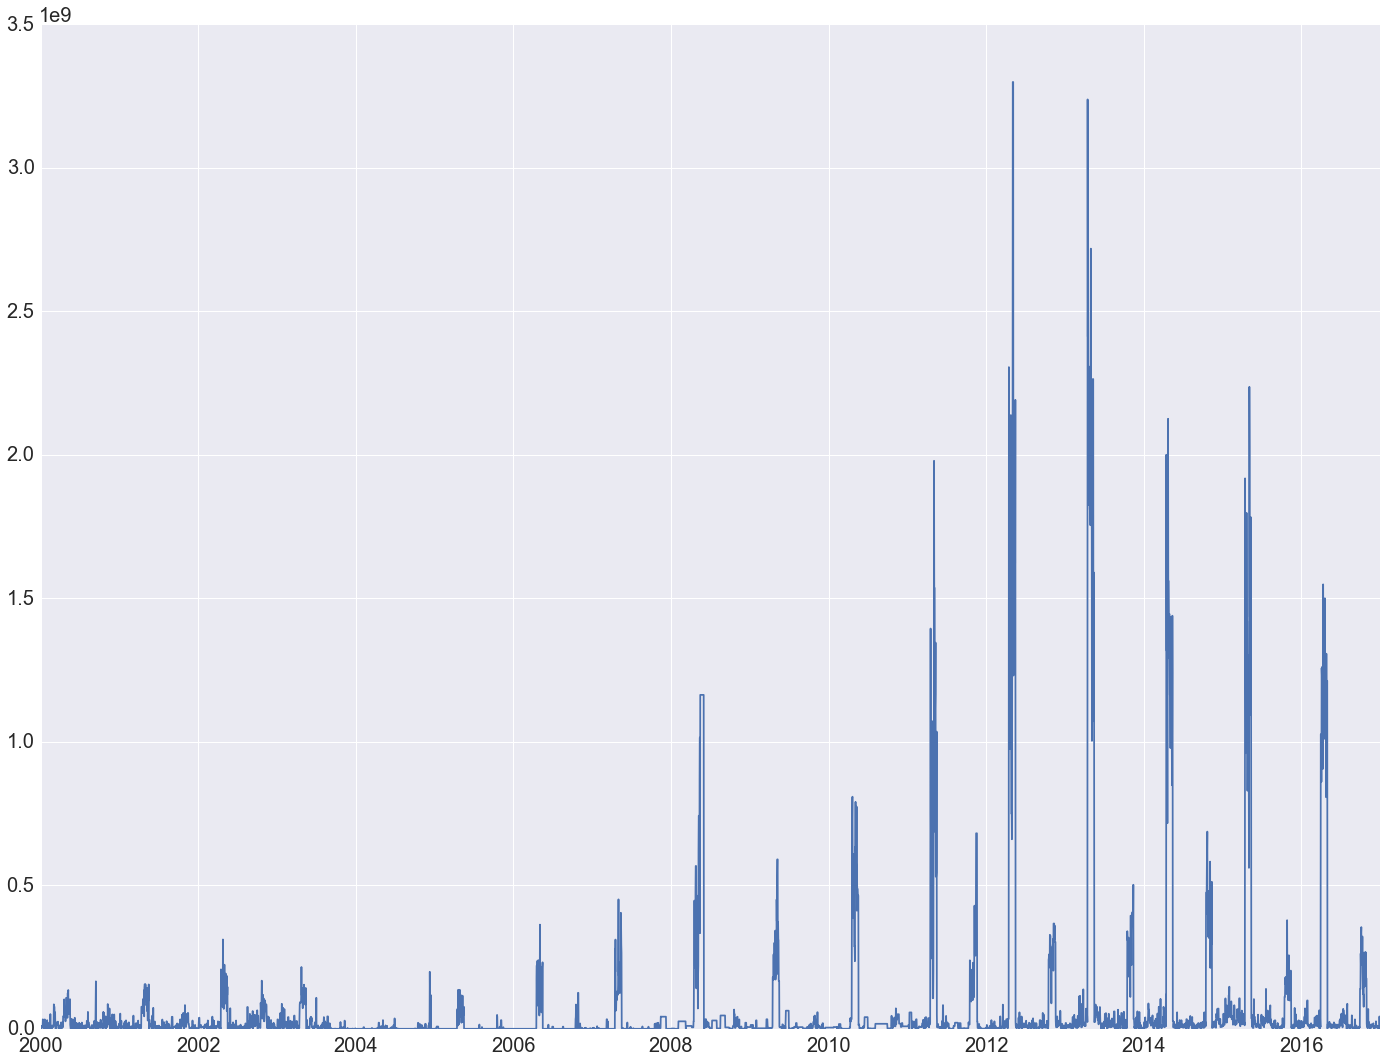

In [52]:
total_vol['ICE-BRENT CRUDE OIL19']['2000':].plot()

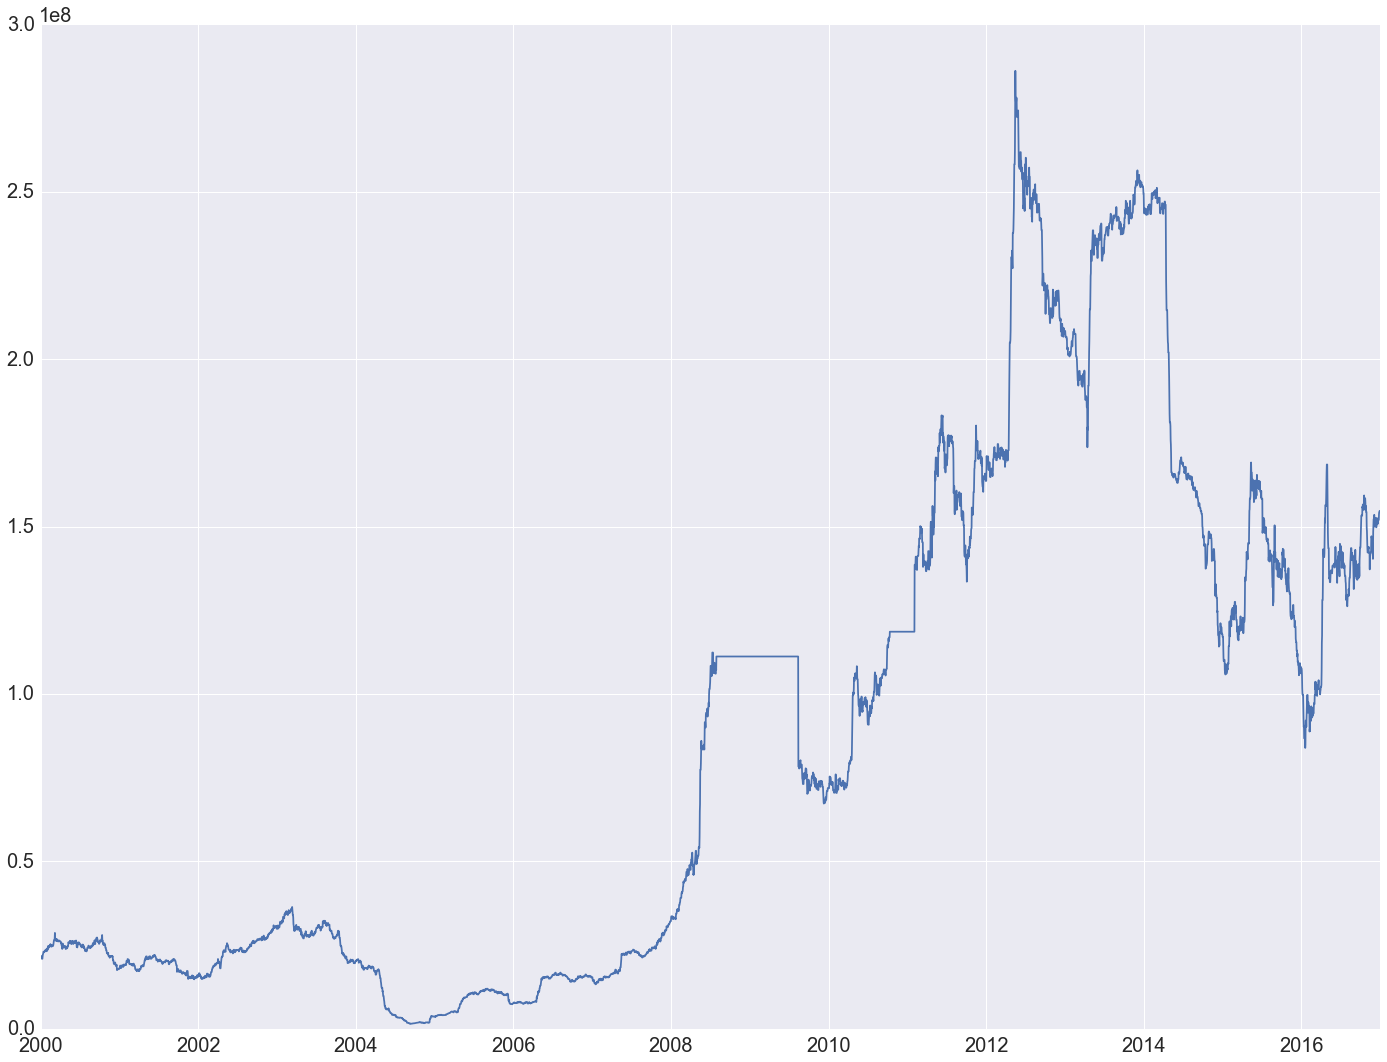

In [50]:
total_vol['ICE-BRENT CRUDE OIL19']['2000':].plot()

In [37]:
temp=pd.DataFrame()
for c in total_vol.columns:
    temp[c]

CMX-HIGH GRADE COPPER1     5.347822e+07
CMX-HIGH GRADE COPPER2     4.967920e+08
CMX-HIGH GRADE COPPER3     4.210327e+08
CMX-HIGH GRADE COPPER4     2.524271e+08
CMX-HIGH GRADE COPPER5     9.331394e+07
CMX-HIGH GRADE COPPER6     3.419072e+07
CMX-HIGH GRADE COPPER7     1.894890e+07
CMX-HIGH GRADE COPPER8     1.118067e+07
CMX-HIGH GRADE COPPER9     6.397644e+06
CMX-HIGH GRADE COPPER10    4.092702e+06
CMX-HIGH GRADE COPPER11    2.445111e+06
CMX-HIGH GRADE COPPER12    1.804348e+06
CMX-HIGH GRADE COPPER13    1.234720e+06
CMX-HIGH GRADE COPPER14    8.992107e+05
CMX-HIGH GRADE COPPER15    2.418170e+07
UK Natural Gas1            3.265961e+09
UK Natural Gas2            1.007920e+09
UK Natural Gas3            3.454630e+08
UK Natural Gas4            2.094155e+08
UK Natural Gas5            1.513700e+08
UK Natural Gas6            1.149032e+08
UK Natural Gas7            7.741146e+07
UK Natural Gas8            6.285500e+07
UK Natural Gas9            3.994469e+07
UK Natural Gas10           3.688076e+07


In [115]:
t=(px[m]/fx[curr]*v[m]*tick_map[m])[:'2016']

In [121]:
t[t<5e8] = np.nan

In [7]:
contract_size=load_maps()

In [142]:
#volume=load_daily_volume()
contract_size=load_maps()
fx=load_fx()
fx_map=contract_size.to_dict()['Currency']
tick_map=contract_size.to_dict()['Tick Value']
fx=fx.resample(rule='d',how='last')
px=cleansed.resample(rule='d',how='last')
total_vol=pd.DataFrame()
for m in cleansed.columns:
    try:
        curr= str(fx_map[m])
        #total_vol[m] = (px[m]/fx[curr]*v[m]*tick_map[m])[:'2016'] 
        t = (px[m]/fx[curr]*volume[m]*tick_map[m])[:'2016'] 
        t[t<5e7] = np.nan
        total_vol[m]=t
    except:
        print(m)
x= (cleansed.pct_change().abs()/ total_vol).resample(rule='m',how='median')


    

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).median()


In [143]:
amihud=x.replace([np.inf, -np.inf,0], np.nan)

In [144]:
temp=sector_XS_normalized(amihud['2000':'2016'],with_equity=True)

In [145]:
sectors_amihud={}
for s in temp.keys():
    if len(temp[s]):
        sectors_amihud[s]=temp[s]

In [146]:
sectors_amihud.keys()

['Energies', 'Agriculturals', 'All', 'Metals']

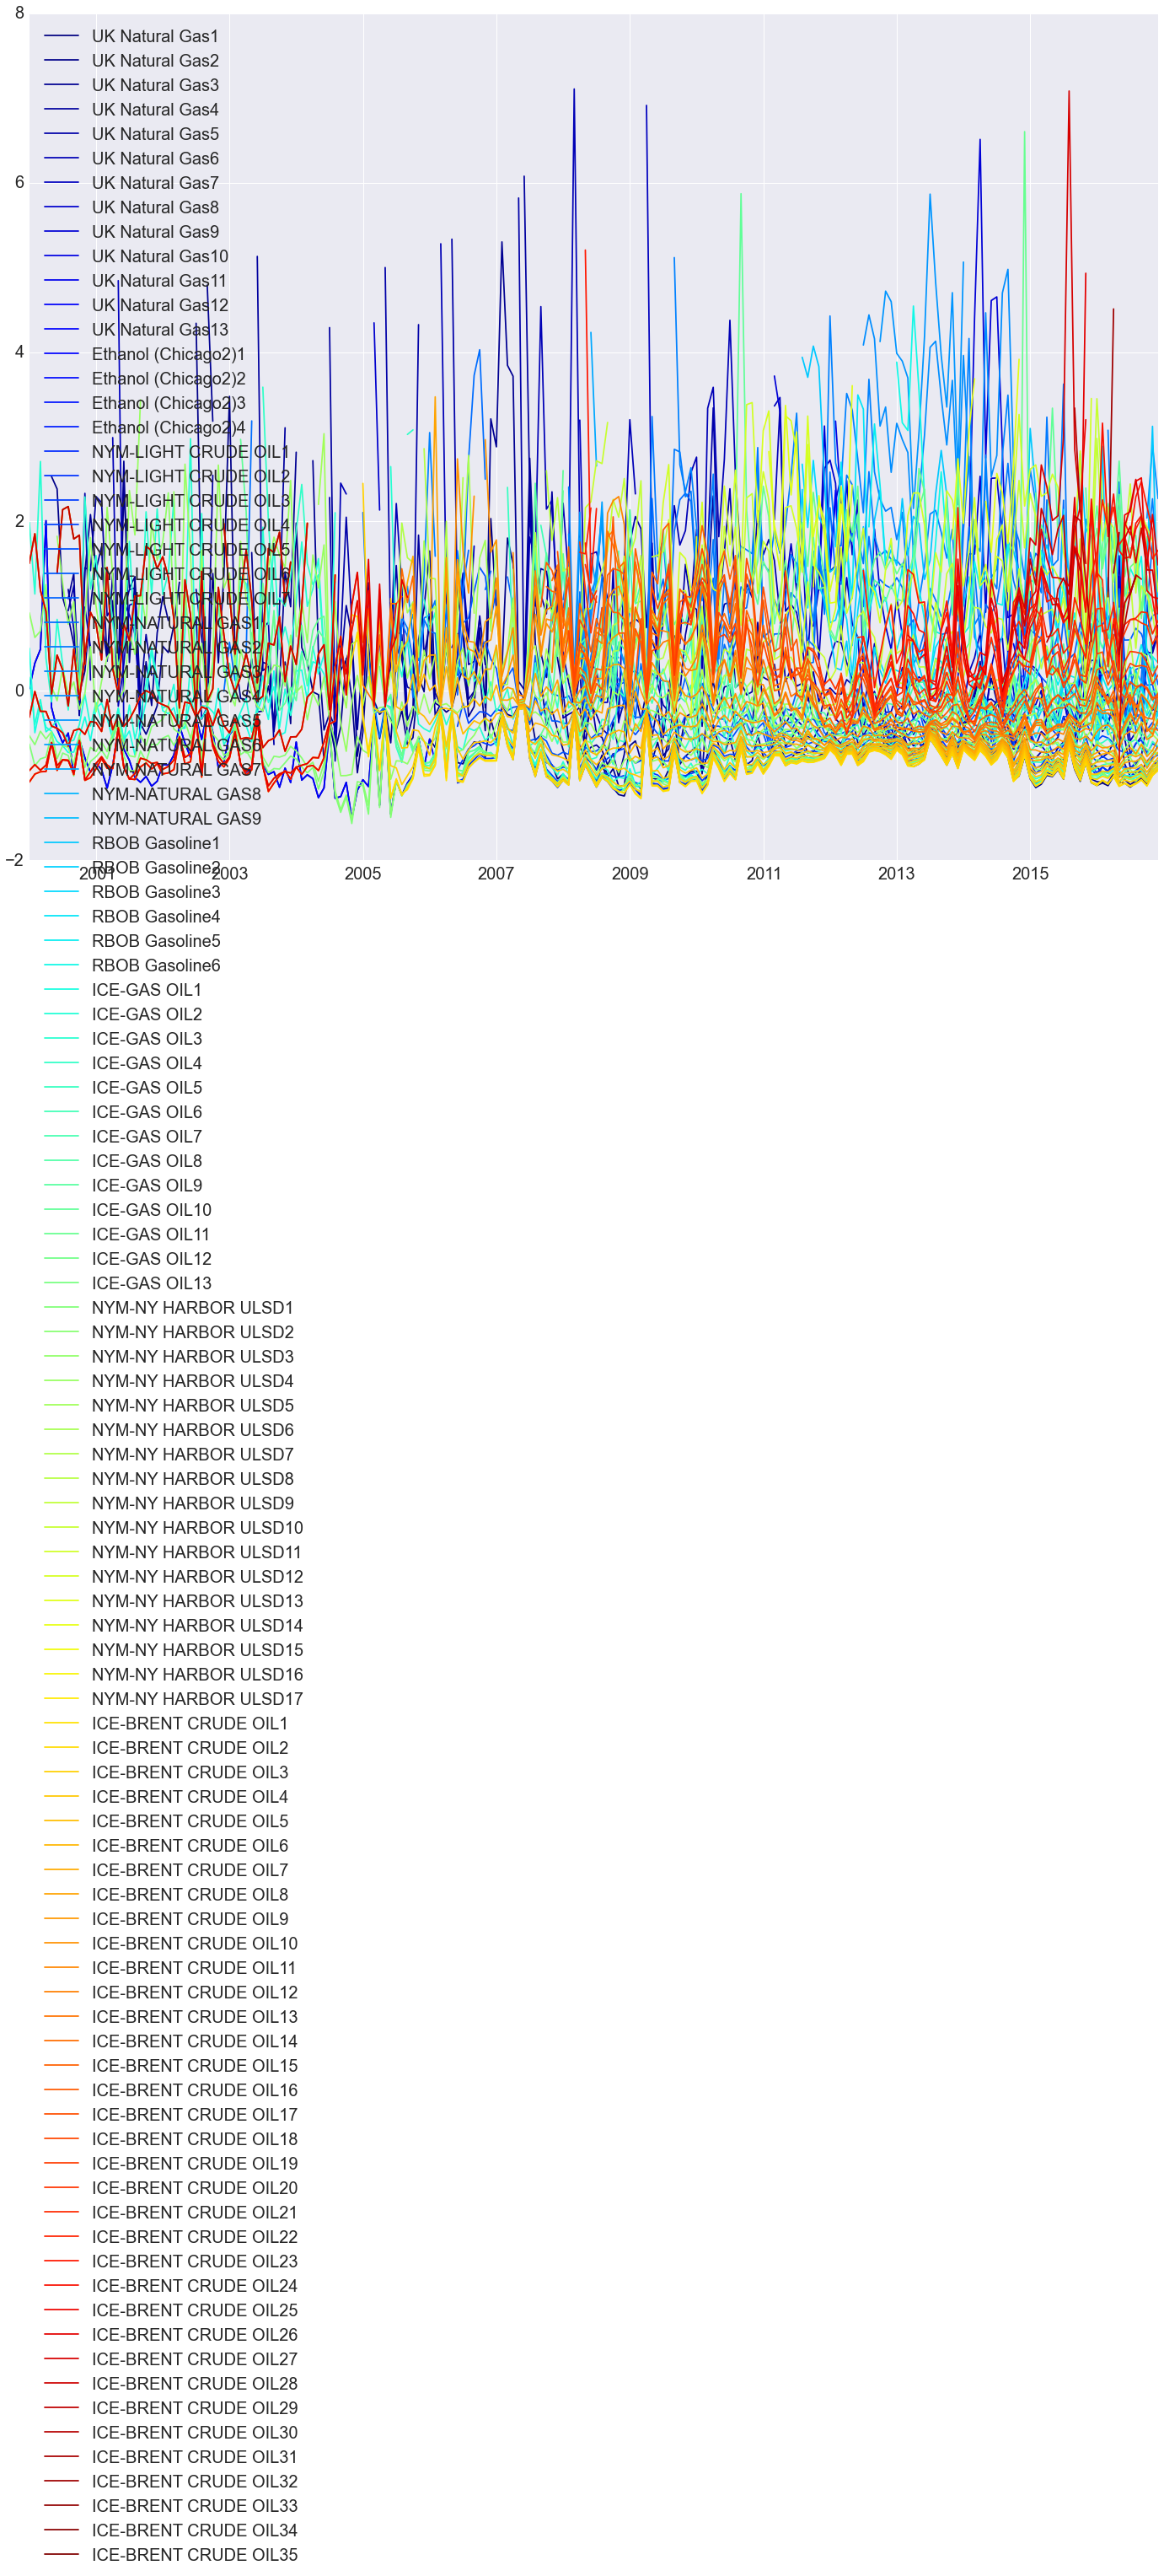

In [147]:
sectors_amihud['Energies'].plot(colormap='jet')

In [163]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in sectors_amihud.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sectors_amihud[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sectors_amihud[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [164]:
sector_PC.keys()

['Energies', 'Agriculturals', 'All', 'Metals']

In [165]:
tcf=pd.DataFrame()
for s in sector_PC.keys():
    tcf[s]=sector_PC[s].mean(axis=1)

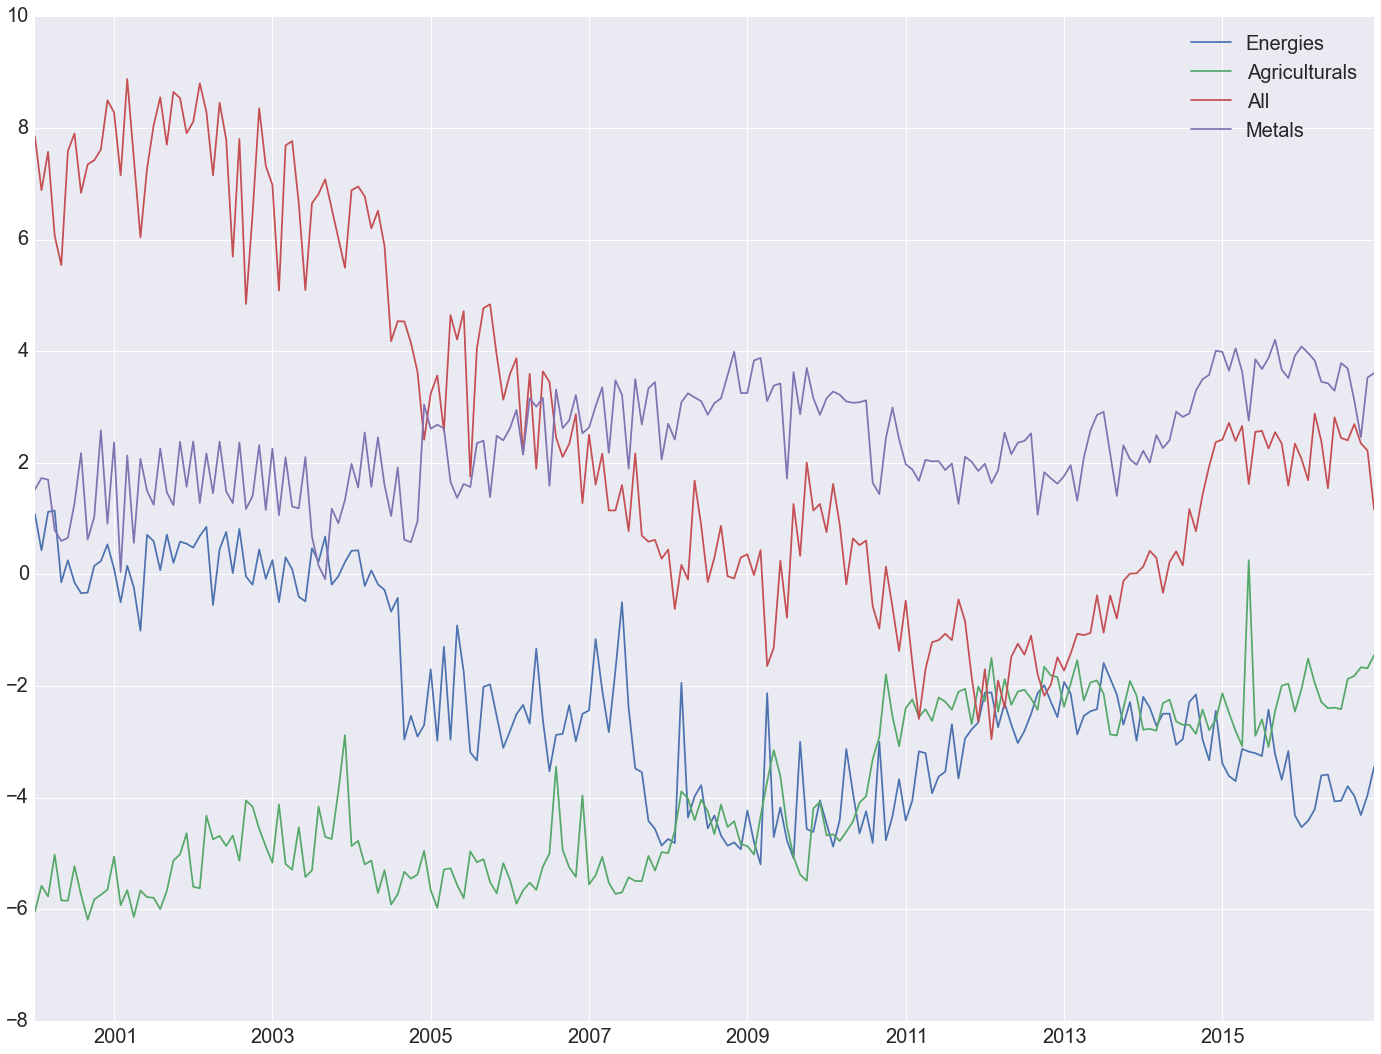

In [166]:
tcf.plot()

In [161]:
FHT_extra=calculate_FHT(cleansed)

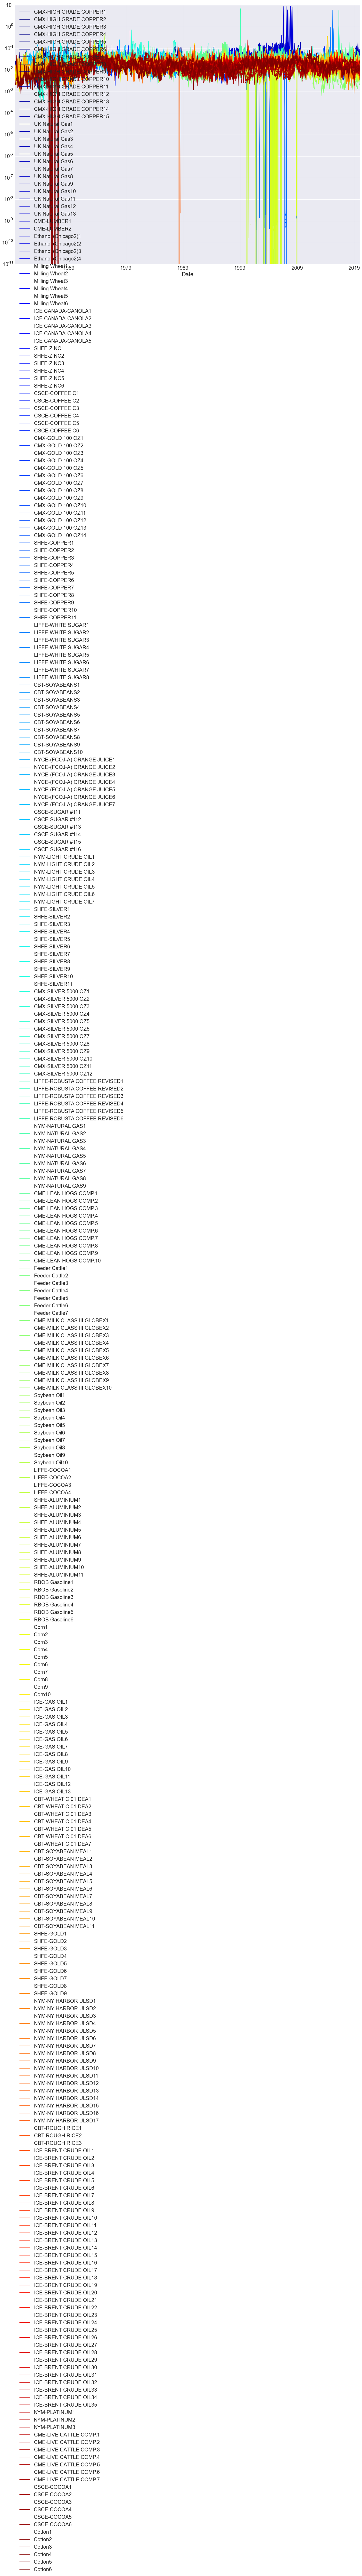

In [162]:
FHT_extra.plot(colormap='jet',logy=True)

In [168]:
temp=sector_XS_normalized(FHT_extra['2000':'2016'],with_equity=True)

In [171]:
sectors_FHT={}
for s in temp.keys():
    if len(temp[s]):
        sectors_FHT[s]=temp[s]

In [173]:
sector_PC_FHT={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in sectors_FHT.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sectors_FHT[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sectors_FHT[sect].index)
            pcs[i]=x
        sector_PC_FHT[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


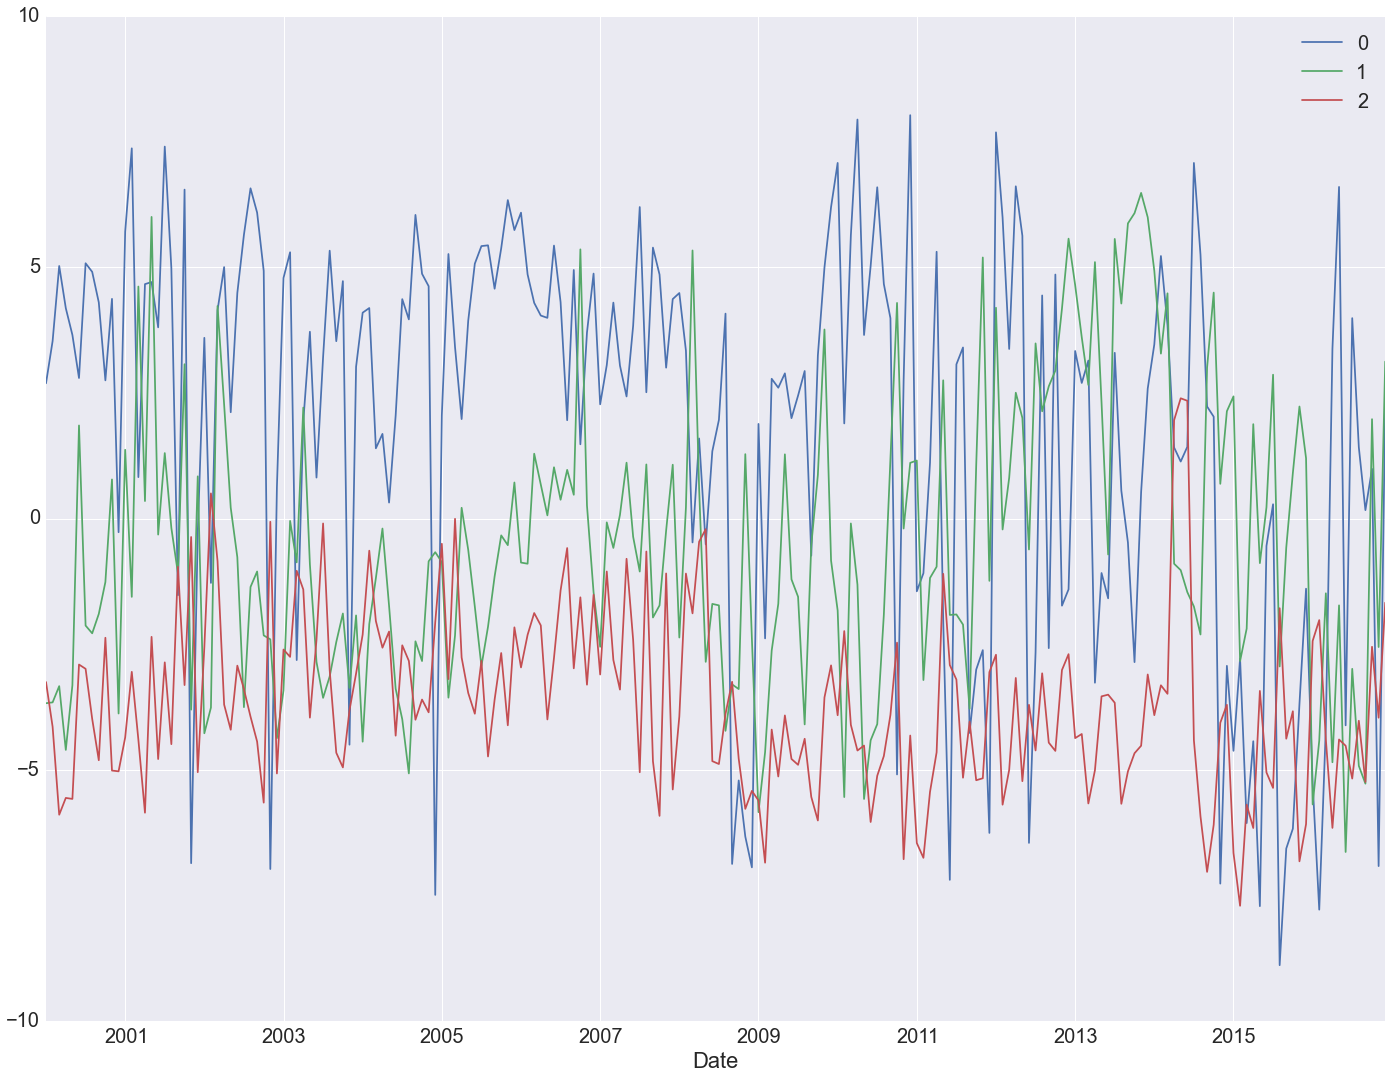

In [175]:
sector_PC_FHT['Energies'].plot()

In [176]:
tcf_fht=pd.DataFrame()
for s in sector_PC_FHT.keys():
    tcf_fht[s]=sector_PC_FHT[s].mean(axis=1)

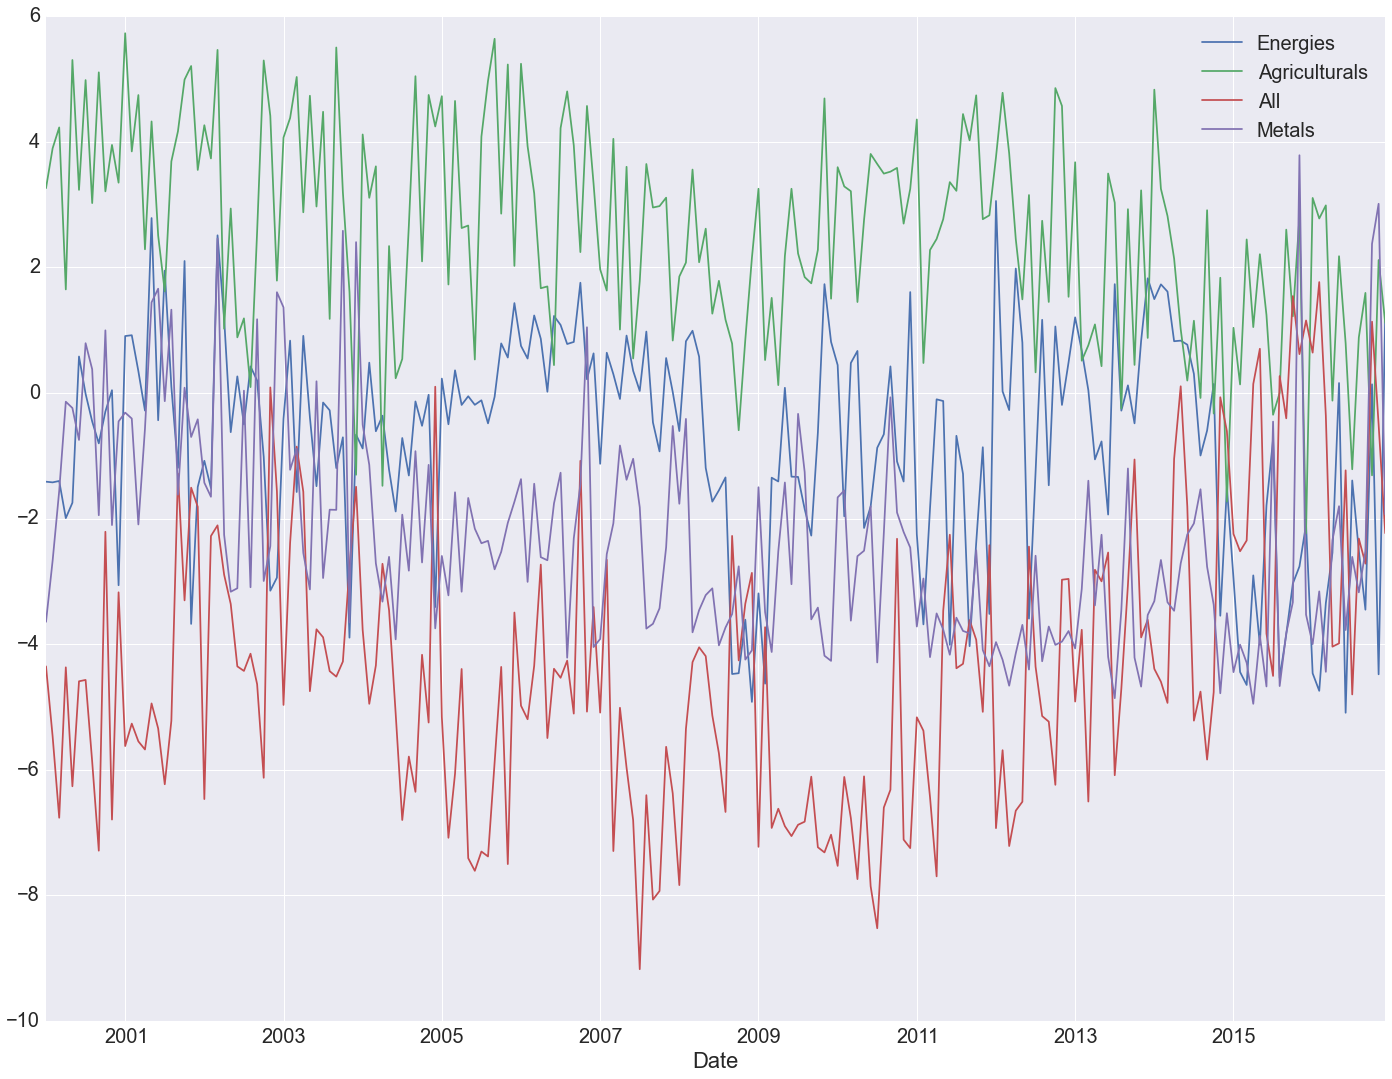

In [177]:
tcf_fht.plot()

In [19]:
#cleansed=load_amihud_markets_price()

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud =\frac{1}{N} \sum \frac{|r_t|}{\text{dvol}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


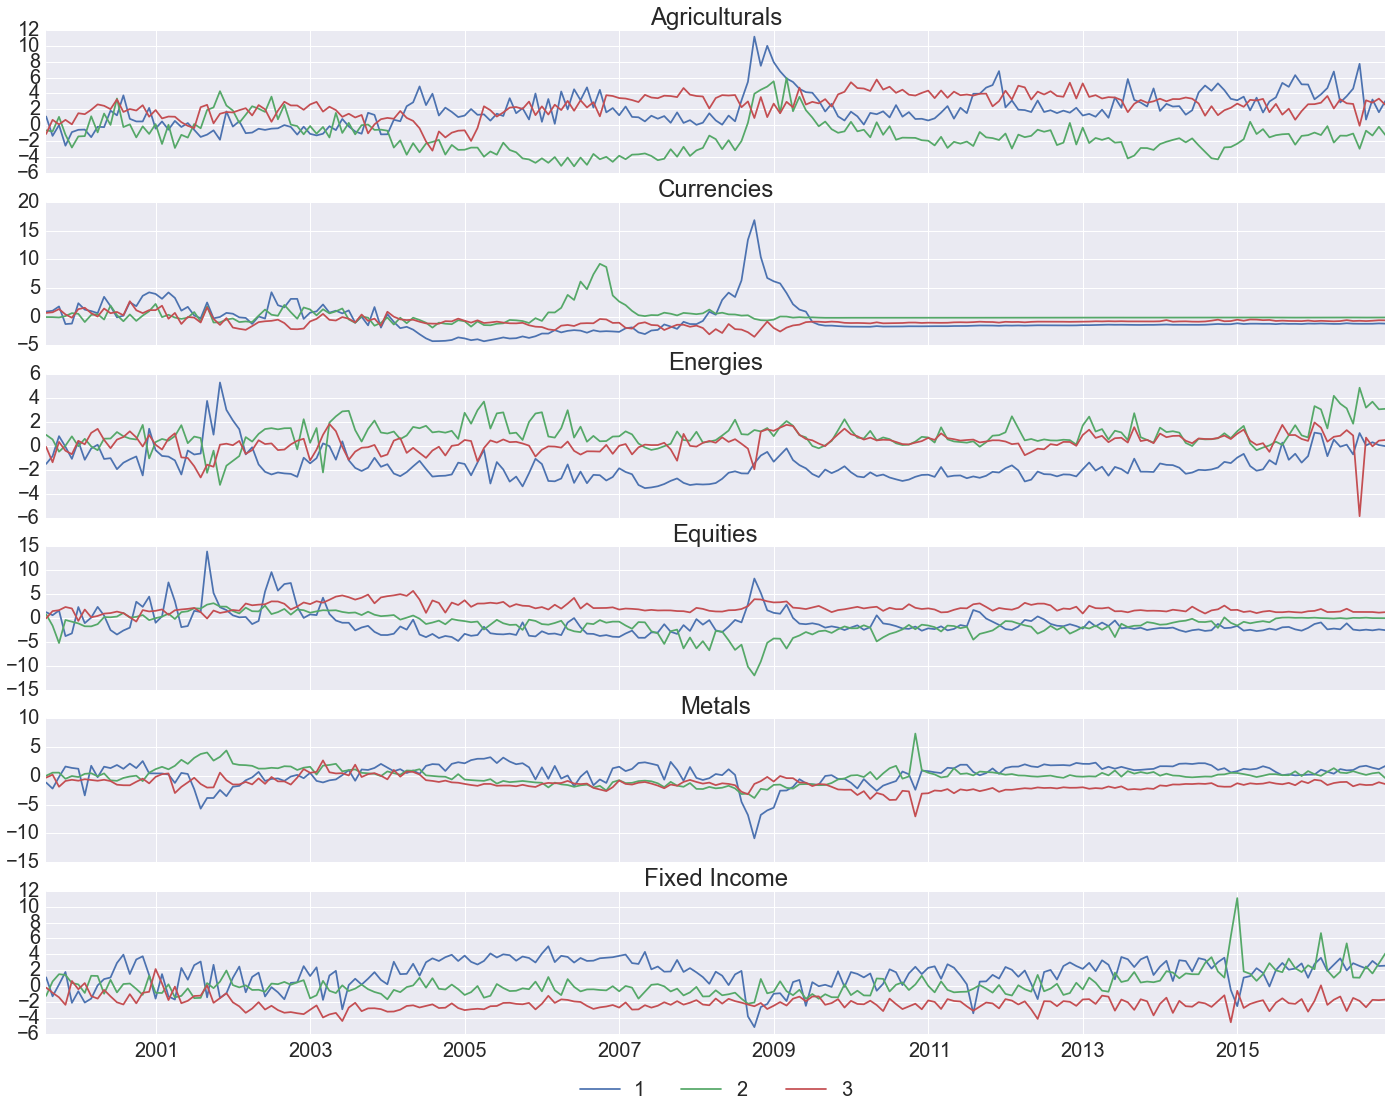

In [48]:
f, a = plt.subplots(len(sector_PC.keys()),1,sharex=True)
i=0
for k in sector_PC.keys():
    sector_PC[k].plot(ax=a[i],title=k,legend=False)
    i=i+1

a[5].legend(handles = a[5] , labels=['A', 'B', 'C'],loc='upper center', 
             bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=False, ncol=3)


# FHT method

In [49]:
FHT=calculate_FHT(cleansed)

tsmom_model.py:360: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  nonzero=x[x==0].resample(rule='m',how='count')
tsmom_model.py:361: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  Z=(nonzero/x.resample(rule='m',how='count')).dropna()
tsmom_model.py:362: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')
tsmom_model.py:362: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data[c]=pd.Series(norm.cdf((1+Z)/2.),index=Z.index)*2*pd.rolling_std(x,12).resample(rule='m',how='last')


In [50]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [51]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [54]:
sector_PC_FHT={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i+1]=x
        sector_PC_FHT[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


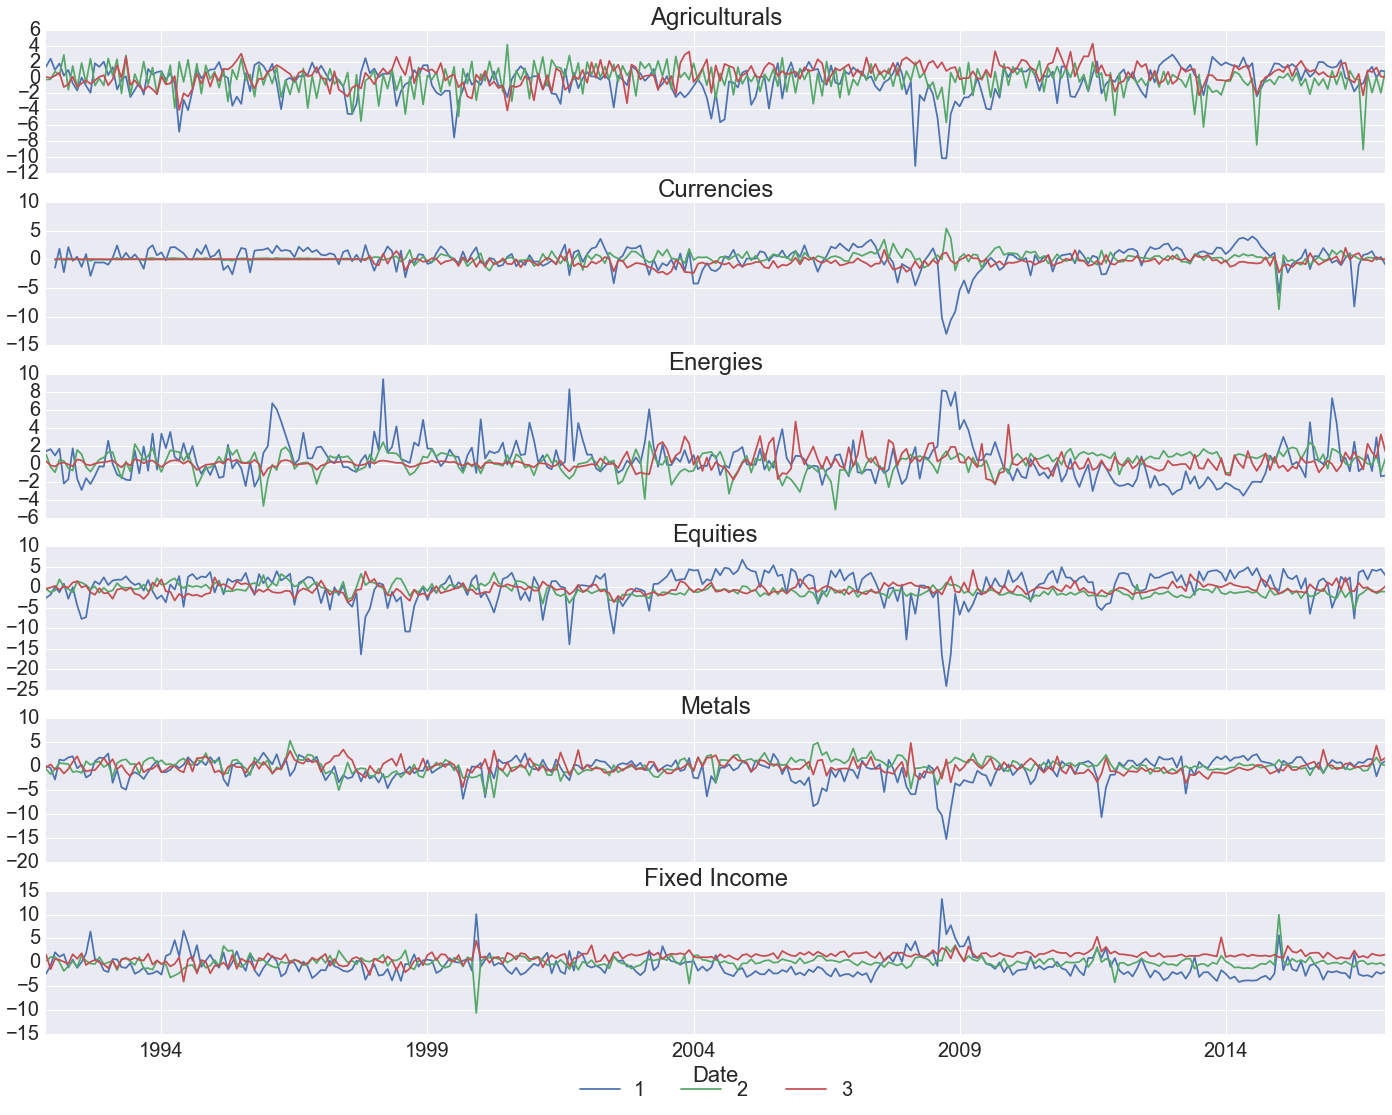

In [55]:
f, a = plt.subplots(len(sector_PC_FHT.keys()),1,sharex=True)
i=0
for k in sector_PC.keys():
    sector_PC_FHT[k].plot(ax=a[i],title=k,legend=False)
    i=i+1

a[5].legend(handles = a[5] , labels=['A', 'B', 'C'],loc='upper center', 
             bbox_to_anchor=(0.5, -0.2),fancybox=True, shadow=False, ncol=3)